# Classificando nomes com uma *Character-Level RNN*

https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

---



### Problema: Dado um nome próprio de entrada, classificar esse nome de acordo com a nacionalidade a que ele pertence.

python predict.py **Hinton**

(-0.47) Scottish

(-1.52) English

(-3.57) Irish


-

python predict.py **Schmidhuber**

(-0.19) German

(-2.48) Czech

(-2.68) Dutch


---
### Import de bibliotecas

In [0]:
import unicodedata
import torch
import string
import torch.nn as nn
from torch.autograd import Variable
import sys, random, os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split as split

args = {
    'lr': 1e-4,
    'weight_decay': 5e-6 
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')


---

### Importando dataset

In [2]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

root_path = 'data/names/'
all_filenames = []
for file_name in os.listdir(root_path):
  all_filenames.append(os.path.join(root_path,file_name))

--2020-02-28 19:09:08--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.253.114, 13.224.253.59, 13.224.253.46, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.253.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2020-02-28 19:09:10 (30.2 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/

In [14]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    #return lines
    return [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [4]:
category_lines['Portuguese'][:5]

[b'Abreu', b'Albuquerque', b'Almeida', b'Alves', b'Araujo']


---
### Convertendo caracteres para tensores
Nesse caso, cada caracter será convertido para uma representação *one-hot*


In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line.decode('utf-8')):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [16]:
tns = letter_to_tensor('a')
print(tns)
print(tns.size())

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])




---


### Funções auxiliares para estruturar as amostras de treino e teste

In [0]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i]

In [0]:
X_train, X_test = {}, {}
for category in all_categories:
  train, test = split(category_lines[category], test_size=0.1)
  
  X_train[category] = train
  X_test[category] = test



---

### Construindo modelo RNN

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (57): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 de acordo com a implementação do loop de treinamento

**Links úteis**

RNNCell: https://pytorch.org/docs/stable/nn.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/nn.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-other



In [70]:
class CustomNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn    = nn.RNNCell(self.input_size, self.hidden_size, nonlinearity='tanh')
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input):
      
        # Set initial hidden state 
        self.hidden = Variable(torch.zeros(1, self.hidden_size).double()).to(args['device']) #GPU
       
        for input_t in input:
          self.hidden = self.rnn(input_t, self.hidden)
        
        output = self.linear(self.hidden)
        output = self.softmax(output) 
        return output

n_hidden = 256
model = CustomNetwork(n_letters, n_hidden, n_categories)
model.double().to(args['device']) #GPU

CustomNetwork(
  (rnn): RNNCell(57, 256)
  (linear): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax()
)



---

### Instanciando *Loss* e Otimizador

In [0]:
criterion = nn.NLLLoss().to(args['device']) #GPU
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])



---

### Treinando / Testando modelo

In [72]:
num_epochs = 20
num_steps  = 2000
print_every = 2000

current_loss = 0
current_acc = 0
all_losses, all_val_losses, all_acc, all_val_acc = [], [], [], []
for epoch in range(num_epochs):  

  for step in range(num_steps):
    
    # Set to Train Mode
    model.train()
    
    category = random.choice(all_categories)
    line = random.choice(X_train[category])
  
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)])).to(args['device']) 
    line_tensor     = Variable(line_to_tensor(line)).double().to(args['device'])

    # Forward pass
    output = model(line_tensor)
    loss = criterion(output, category_tensor)
    current_loss += loss
    current_acc  += 1 if category_from_output(output) == category else 0
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1) % print_every == 0:
      
      #Set to evaluation mode
      model.eval()
      n_test_steps = 100
      
      test_loss, acc = 0, 0
      for tstep in range(n_test_steps):
      
        category = random.choice(all_categories)
        line = random.choice(X_test[category])

        category_tensor = Variable(torch.LongTensor([all_categories.index(category)])).to(args['device'])
        line_tensor     = Variable(line_to_tensor(line)).double().to(args['device'])

        output = model(line_tensor)
        loss = criterion(output, category_tensor)
        test_loss += loss
        acc += 1 if category_from_output(output) == category else 0
      
      
      current_loss = current_loss.item()/float(print_every)
      current_acc  = current_acc/float(print_every)
      test_loss    = test_loss.item()/float(n_test_steps)
      acc          = acc/float(n_test_steps)
      
      print('\rEpoch: {:2} Train Loss: {:.3f} Train Acc: {:.2f}% Val Loss: {:.3f}  Val Acc: {:.2f}%'.format(epoch+1, current_loss, current_acc*100, test_loss, acc*100))

      all_losses.append(current_loss)
      all_acc.append(current_acc)
      all_val_losses.append(test_loss)
      all_val_acc.append(acc)

      current_loss = 0
      current_acc  = 0
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  1 Train Loss: 2.711 Train Acc: 14.85% Val Loss: 2.588  Val Acc: 17.00%
Epoch:  2 Train Loss: 2.442 Train Acc: 22.20% Val Loss: 2.300  Val Acc: 22.00%
Epoch:  3 Train Loss: 2.263 Train Acc: 29.55% Val Loss: 2.156  Val Acc: 29.00%
Epoch:  4 Train Loss: 2.119 Train Acc: 34.60% Val Loss: 2.033  Val Acc: 30.00%
Epoch:  5 Train Loss: 2.006 Train Acc: 37.60% Val Loss: 1.920  Val Acc: 44.00%
Epoch:  6 Train Loss: 1.934 Train Acc: 39.60% Val Loss: 1.750  Val Acc: 51.00%
Epoch:  7 Train Loss: 1.829 Train Acc: 43.85% Val Loss: 1.738  Val Acc: 46.00%
Epoch:  8 Train Loss: 1.731 Train Acc: 46.80% Val Loss: 1.875  Val Acc: 39.00%
Epoch:  9 Train Loss: 1.691 Train Acc: 44.95% Val Loss: 1.737  Val Acc: 42.00%
Epoch: 10 Train Loss: 1.588 Train Acc: 49.25% Val Loss: 1.833  Val Acc: 38.00%
Epoch: 11 Train Loss: 1.564 Train Acc: 50.40% Val Loss: 1.710  Val Acc: 39.00%
Epoch: 12 Train Loss: 1.547 Train Acc: 51.25% Val Loss: 1.584  Val Acc: 46.00%
Epoch: 13 Train Loss: 1.496 Train Acc: 51.70% Val Lo



---


### Análise e plots

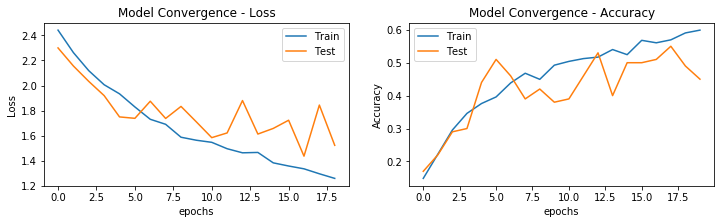

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))


ax1.plot(all_losses[1:], label='Train')
ax1.plot(all_val_losses[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(all_acc, label='Train')
ax2.plot(all_val_acc, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()



---

### Fazendo predições com entradas de usuário

In [83]:
def predict_input(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    
    tensor = torch.zeros(len(input_line),1, n_letters)
    for li, letter in enumerate(input_line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
        
    output = model(Variable(tensor).double().cuda())

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict_input('Mbape')
predict_input('Guillermo')
predict_input('Kyle')


> Mbape
(-1.38) Scottish
(-1.57) French
(-1.84) English

> Guillermo
(-0.54) Portuguese
(-1.62) Italian
(-1.77) Spanish

> Kyle
(-1.16) Scottish
(-1.67) English
(-2.10) Russian


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
